<a href="https://colab.research.google.com/github/EricDeop/NLP--Spacy-Preprocessing-/blob/Spacy-Pre-Processing/Spacy_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive')

import numpy as np
import pandas as pd

path = "/content/drive/MyDrive/LeaderComment.csv"

df = pd.read_csv(path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,SURVEYRESPONDERID,AVERAGE_RESPONSE_DATE,YEAR,MONTH,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,1/7/21,2021,1,Male,30013,Melvins professional demeanor and interpersona...
1,17311889,1/7/21,2021,1,Female,30014,Proved better supervision and support.
2,17334983,1/7/21,2021,1,Male,30013,Proven experience
3,17340598,1/2/21,2021,1,Male,30014,"Let the team do what they were hired to do, so..."
4,17340874,1/2/21,2021,1,Male,30013,They consistently look for opportunities to ma...


In [3]:
#Importing necessary packages
import spacy
import re
import string
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Limiting gender category to Survery Companys default answers (male, female, prefer not to answer(PNTA))

print(df['GENDER'].value_counts())

df['GENDER'] = df['GENDER'].str.lower()

df = df.replace({'GENDER' : {'do not wish to disclose' : 'prefer not to answer',
                        'cisgender' : 'gender not listed', 'm' : 'male', 
                        'f' : 'female'}})

df = df[df["GENDER"].str.contains(
    "non-binary|other gender|gender not listed|gender identity not listed|other gender"
    ) == False]

print("\n")

df['GENDER'].value_counts()

Female                        96058
Male                          84822
Prefer not to answer          24270
Non-binary                     1377
Other gender                    334
Prefer Not To Answer             28
Do not wish to disclose          28
M                                18
F                                13
Gender identity not listed        6
Cisgender                         6
Gender Not Listed                 1
Name: GENDER, dtype: int64




female                  96071
male                    84840
prefer not to answer    24326
Name: GENDER, dtype: int64

In [5]:
#Removing duplicates
#Survey responder ID - Duplicate survey ID indicates same person
#cannot ascertain if duplicate comments exist that they are from the same person
#left comments as is and the other columns too

ids = df['SURVEYRESPONDERID']
duplicates = ids[ids.duplicated()]

print("Duplicate ID's :", duplicates.value_counts().sum(),"\n")

df = df.drop_duplicates(subset=['SURVEYRESPONDERID'])
print("Rows, Columns after Duplicate ID's removed: ",df.shape)

Duplicate ID's : 24 

Rows, Columns after Duplicate ID's removed:  (205213, 7)


In [6]:
#Removing Nan Values

print(df.isna().sum().sort_values(ascending = False))

#NaN values only found in comment column
#Removal of those 4 comments

df = df.dropna()

df.shape

COMMENT                    4
SURVEYRESPONDERID          0
AVERAGE_RESPONSE_DATE      0
YEAR                       0
MONTH                      0
GENDER                     0
SURVEYQUESTIONESSENCEID    0
dtype: int64


(205209, 7)

#Dropping AVERAGE_RESPONSE_DATE, YEAR, and MONTH columns as they will not be relevant to this analysis

In [7]:
df = df.drop(columns=['AVERAGE_RESPONSE_DATE', 'YEAR', 'MONTH'], axis=1)
df.head()

,SURVEYRESPONDERID,GENDER,SURVEYQUESTIONESSENCEID,COMMENT
0,17296164,male,30013,Melvins professional demeanor and interpersona...
1,17311889,female,30014,Proved better supervision and support.
2,17334983,male,30013,Proven experience
3,17340598,male,30014,"Let the team do what they were hired to do, so..."
4,17340874,male,30013,They consistently look for opportunities to ma...


In [8]:
# Converting all text to lowercase and removing punctuations

def clean_text(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]',' ', text)
  text = re.sub('\[.*?\#]', '', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  return text

cleaning = lambda x: clean_text(x)

In [9]:
df_clean = pd.DataFrame(df['COMMENT'].apply(cleaning))

df["COMMENT"] = df_clean

print(df['COMMENT'].head(10),"\n")
print(df['COMMENT'].tail(10))

0    melvins professional demeanor and interpersona...
1               proved better supervision and support 
2                                   proven experience 
3    let the team do what they were hired to do  so...
4    they consistently look for opportunities to ma...
5    willingness to terminate bad employees  commit...
6    calm  fearless  godliness of character  respec...
7    it doesnt  you have a manager that wife works ...
8    quit pitting the different shifts and departme...
9    pay me what i deserve based on my qualificatio...
Name: COMMENT, dtype: object 

206951               good at communicating what is required
206952                 employ composite industry managers  
206953                        drug test and stick to policy
206954                     passion and drive for results   
206955    spend money in the right areas   stop employin...
206956    his open and willingness to describe what is g...
206957    howard makes sure that we feel safe and feel c...

In [10]:
#Tokenization

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(df["COMMENT"]))

print(data_words[:1])

[['melvins', 'professional', 'demeanor', 'and', 'interpersonal', 'skills', 'inspire', 'confidence']]


In [11]:
print(data_words[:2])

[['melvins', 'professional', 'demeanor', 'and', 'interpersonal', 'skills', 'inspire', 'confidence'], ['proved', 'better', 'supervision', 'and', 'support']]


In [12]:
#Bigrams

bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10)

In [13]:
data_words = [bigram[line] for line in data_words]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [14]:
print(data_words[0])

print("\ninterpersonal_skills is indicated by bigram with underscore")

['melvins', 'professional', 'demeanor', 'and', 'interpersonal_skills', 'inspire', 'confidence']

interpersonal_skills is indicated by bigram with underscore


#Removing stop words from texts

In [15]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

nlp = spacy.load('en_core_web_lg', disable = ['parser','ner'])

print(nlp.Defaults.stop_words)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
{'but', 'for', 'we', 'same', 'if', 'throughout', 'front', 'further', 'get', 'nothing', 'own', 'what', 'empty', 'cannot', 'its', 'much', 'after', 'i', 'several', 'not', 'nine', 'yourself', 'because', 'amount', 'various', 'via', 'those', 'namely', 'might', 'ourselves', 'in', 'put', 'there', 'him', 'beforehand', 'thence', 'will', 'within', '‘d', 'toward', 'whence', 'also', 'to', 'two', 'such', 'whereby', 'please', 'this', 'back', 'mine', 'were', 'with', 'keep', 'across', 'however', 'whom', 'from', 'both', 'never', 'say', 'eleven', 'either', 'on', 'whereupon', 'who', 'somewhere', 'himself', 'indeed', 'out', 'into', 'been', '’re', '‘m', 'therefore', 'me', '’ll', 'sometimes', 'often', 'beside', 'may', 'towards', 'become', 'ten', 'her', 'thus', 'amongst', 'used', 'hereby', 'anyone', 'five', 'seeming', 're', 'latterly', 'he', 'something', 'although', 'hereupon', 'before', '’m', 'which', 'an', '

In [16]:
#Adding my own stop words to list to get a better topic model

nlp.Defaults.stop_words |= {'employees', 'company', 'work', 'people', 
                            'like', 'feel', 'leadership','know', 'time', 
                            'staff', 'better', 'leader', 'good', 'team', 'don',
                 'confidence', 'great', 'ceo', 'care', 'new', 'job', 'business',
                  'things', 'listen', 'decisions','doesn','u'}

In [17]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts]

In [18]:
data_words_nostops = remove_stopwords(data_words)

In [19]:
#Removing bigrams from words for better topic modeling

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)

In [20]:
data_words_bigrams[5:11]

[['willingness', 'terminate', 'bad', 'commitment', 'standard', 'maintaining'],
 ['calm', 'fearless', 'godliness', 'character', 'respectful', 'cares_about'],
 ['doesnt', 'manager', 'wife', 'works', 'regular', 'employee', 'away'],
 ['quit',
  'pitting',
  'different',
  'shifts',
  'departments',
  'each_other',
  'treat',
  'fairly',
  'quit',
  'make_sure',
  'distribution',
  'equal',
  'make_sure',
  'pulling',
  'weight',
  'task',
  'suited',
  'ones',
  'personality',
  'try',
  'different'],
 ['pay',
  'deserve',
  'based_on',
  'qualifications',
  'stop_treating',
  'an_intern'],
 ['truly',
  'understand',
  'respect',
  'position',
  'day',
  'day',
  'lead',
  'mean',
  'position',
  'interact_with',
  'different_types',
  'callers',
  'stakeholders']]

In [21]:
long_list = [item for sublist in data_words_bigrams for item in sublist]                      

In [22]:
print(len(long_list))

1536927


In [23]:
long_string = ' '.join(long_list)

print(long_string[0])

m


(-0.5, 999.5, 599.5, -0.5)

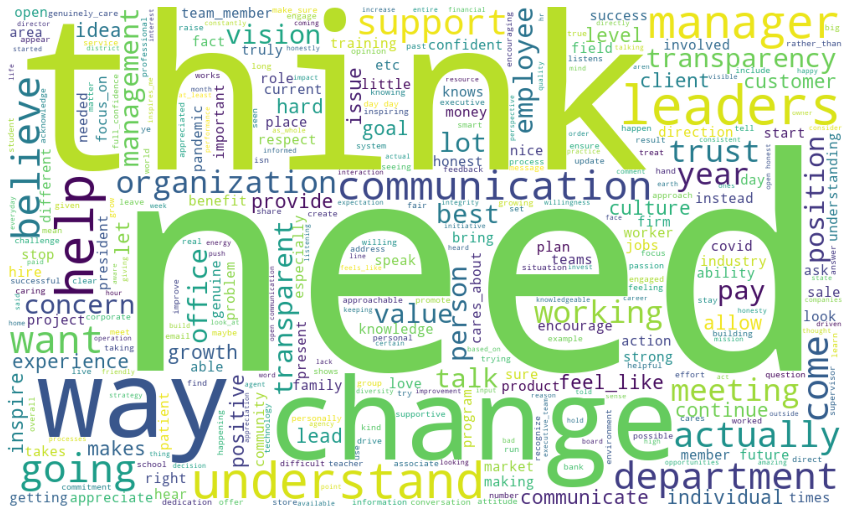

In [24]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", 
               max_words=350, 
               width=1000, 
               height=600, 
               random_state=1).generate(long_string)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")

#Lemmatization with Parts of speech tagging

In [25]:
nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = [
    'NOUN','ADJ', 'VERB','ADV'])

print(data_lemmatized[:1])

[['melvin', 'professional', 'demeanor', 'inspire']]


In [26]:
nlp.Defaults.stop_words |= {"u", "employee", 'company','work','make','people','leader',
            'like','care', 'seems','things','good','feel','know','always',
            'inspires','get','leadership','well','thing','employees'}

In [27]:
print(nlp.Defaults.stop_words)

{'but', 'for', 'we', 'same', 'if', 'throughout', 'front', 'further', 'get', 'nothing', 'own', 'what', 'confidence', 'empty', 'cannot', 'its', 'much', 'after', 'i', 'several', 'not', 'nine', 'yourself', 'because', 'amount', 'u', 'various', 'via', 'those', 'great', 'namely', 'might', 'ourselves', 'in', 'put', 'there', 'him', 'beforehand', 'thence', 'will', 'within', '‘d', 'toward', 'things', 'whence', 'listen', 'also', 'to', 'two', 'such', 'whereby', 'please', 'this', 'back', 'mine', 'ceo', 'were', 'with', 'keep', 'across', 'however', 'company', 'whom', 'from', 'both', 'never', 'say', 'eleven', 'either', 'don', 'on', 'whereupon', 'who', 'somewhere', 'himself', 'indeed', 'out', 'into', 'been', '’re', '‘m', 'therefore', 'me', '’ll', 'job', 'sometimes', 'often', 'beside', 'may', 'towards', 'become', 'like', 'ten', 'her', 'thus', 'amongst', 'used', 'hereby', 'anyone', 'five', 'seeming', 're', 'latterly', 'he', 'something', 'although', 'hereupon', 'before', '’m', 'which', 'an', 'one', 'staff'

In [28]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in nlp.Defaults.stop_words] for doc in texts]

In [29]:
datawords_nostops = remove_stopwords(data_lemmatized)

In [30]:
pip install textacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
print(data_words_nostops[:3])

[['melvins', 'professional', 'demeanor', 'inspire'], ['proved', 'supervision', 'support'], ['proven', 'experience']]


#Creating corpus for TOPIC MODELING

In [32]:
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"need" + 0.023*"understand" + 0.019*"come" + 0.016*"concern" + '
  '0.015*"industry" + 0.014*"provide" + 0.014*"value" + 0.013*"support" + '
  '0.013*"direction" + 0.012*"future"'),
 (1,
  '0.019*"make" + 0.017*"want" + 0.017*"think" + 0.016*"way" + 0.015*"open" + '
  '0.015*"manager" + 0.014*"communication" + 0.014*"work" + 0.013*"day" + '
  '0.011*"talk"'),
 (2,
  '0.035*"change" + 0.027*"go" + 0.017*"transparent" + 0.015*"actually" + '
  '0.015*"position" + 0.015*"level" + 0.015*"growth" + 0.014*"trust" + '
  '0.014*"success" + 0.014*"office"'),
 (3,
  '0.026*"help" + 0.020*"leader" + 0.020*"pay" + 0.015*"year" + 0.015*"grow" + '
  '0.013*"goal" + 0.012*"vision" + 0.012*"continue" + 0.012*"customer" + '
  '0.012*"meeting"')]


In [35]:
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.2 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=e2a1574174a76d068bfcce20a18b84d5b64d9ce407d49b2868fb0af0640b23dc
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
import pyLDAvis
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
